In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

sns.set_style('darkgrid')
%matplotlib inline

In [36]:
df = pd.read_csv('./term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Description

> **Age:** Age of customer  
> **Job:** Type of job  
> **Marital:** Marital status   
> **Education:**  
> **Default:** Has credit in default?  
> **Balance:** Average yearly balance, in euros  
> **Housing:** Has a housing loan?  
> **Loan:** Has personal loan?  
> **Contact:** Contact communication type  
> **Day:** Last contact day of the month  
> **Month:** Last contact month of year  
> **Duration:** Last contact duration, in seconds  
> **Campaign:** Number of contacts performed during this campaign and for this client (includes last contact)  

# Data Preparation

In [3]:
## check for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df['job'].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [5]:
df['education'].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [6]:
df['contact'].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

Even though there are no null values in the dataset, there are 'unknown' values in the job, education, and contact columns. Most of the unknown values are a small part of the column other than contact. Let's take a look and see if there is any way to fill in the unknown values.

In [7]:
df.loc[(df['education'] == 'unknown') & (df['job'] == 'blue-collar')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
42,60,blue-collar,married,unknown,no,104,yes,no,unknown,5,may,22,1,no
57,47,blue-collar,married,unknown,no,306,yes,no,unknown,5,may,13,1,no
58,40,blue-collar,single,unknown,no,24,yes,no,unknown,5,may,185,1,no
64,49,blue-collar,married,unknown,no,154,yes,no,unknown,5,may,357,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39286,32,blue-collar,single,unknown,no,258,yes,no,cellular,18,may,291,2,no
39349,37,blue-collar,married,unknown,no,-118,yes,no,cellular,18,may,21,2,no
39426,53,blue-collar,married,unknown,no,2509,no,no,telephone,22,may,231,2,yes
39701,24,blue-collar,single,unknown,no,192,no,no,cellular,27,may,424,1,no


In [8]:
df.loc[(df['job'] == 'blue-collar')]['education'].value_counts()

secondary    5144
primary      3673
unknown       439
tertiary      127
Name: education, dtype: int64

In [9]:
df.loc[(df['job'] == 'management')]['education'].value_counts()

tertiary     6667
secondary    1037
primary       273
unknown       189
Name: education, dtype: int64

In [10]:
df.loc[(df['job'] == 'technician')]['education'].value_counts()

secondary    4788
tertiary     1702
unknown       214
primary       148
Name: education, dtype: int64

In [11]:
df.loc[(df['job'] == 'admin')]['education'].value_counts()

secondary    3723
tertiary      410
primary       202
unknown       148
Name: education, dtype: int64

In [12]:
df.loc[(df['job'] == 'services')]['education'].value_counts()

secondary    3269
primary       336
tertiary      170
unknown       135
Name: education, dtype: int64

In [13]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [14]:
df.loc[(df['y'] == 'yes')].describe()

,age,balance,day,duration,campaign
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365
std,11.001984,2924.894429,8.557604,431.287174,2.306015
min,19.000000,-3058.000000,1.000000,8.000000,1.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000


In [15]:
df.loc[(df['y'] == 'no')].describe()

,age,balance,day,duration,campaign
count,37104.000000,37104.000000,37104.000000,37104.000000,37104.000000
mean,40.599208,1249.752533,16.032072,221.408042,2.918688
std,9.525450,2900.722436,8.255850,206.360022,3.298031
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,50.000000,8.000000,95.000000,1.000000
50%,39.000000,395.000000,17.000000,164.000000,2.000000
75%,48.000000,1286.000000,21.000000,280.000000,3.000000
max,94.000000,102127.000000,31.000000,4918.000000,63.000000


Taking a look at the difference in customers who sign up for a term deposit and those that don't, the only continuous feature that has a noticeable difference is the duration of the phone call. The customers who sign up are on the phone much longer than those that are not interested with the average duration being 11 minutes for customers who sign up and ~4 minutes for those who don't. The average yearly balance for those who sign up is also slightly higher than those who don't but the difference is not very significant.

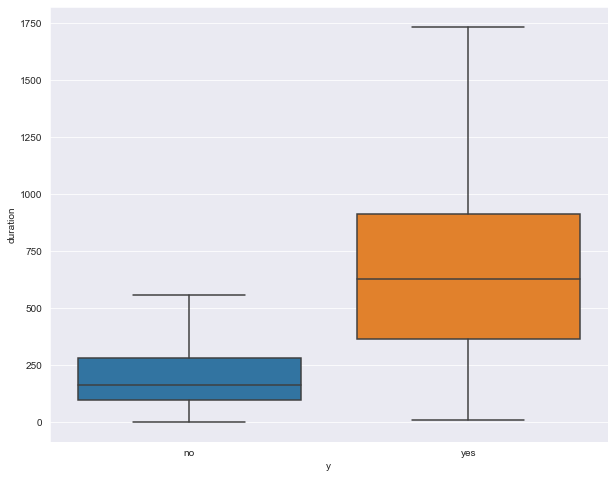

In [16]:
## graph the difference in duration to see the discrepancy more easily

plt.figure(figsize=(10, 8))
sns.boxplot(x='y', y='duration', data=df, showfliers=False)
plt.show()

Looking at this graph it is easy to see how much longer a customer that is interested will stay on the call. Most calls with customers that sign up for a term deposit are 

In [17]:
print(f'Number of yes for cellular: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "cellular")])}')
print(f'Number of no for cellular: {len(df.loc[(df["y"] == "no") & (df["contact"] == "cellular")])}')
print(f'Ratio of yes to no for cellular: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "cellular")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "cellular")])}\n')

print(f'Number of yes for telephone: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "telephone")])}')
print(f'Number of no for telephone: {len(df.loc[(df["y"] == "no") & (df["contact"] == "telephone")])}')
print(f'Ratio of yes to no for telephone: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "telephone")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "telephone")])}\n')

print(f'Number of yes for unknown: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "unknown")])}')
print(f'Number of no for unknown: {len(df.loc[(df["y"] == "no") & (df["contact"] == "unknown")])}')
print(f'Ratio of yes to no for unknown: {len(df.loc[(df["y"] == "yes") & (df["contact"] == "unknown")])/len(df.loc[(df["y"] == "no") & (df["contact"] == "unknown")])}\n')

Number of yes for cellular: 2233
Number of no for cellular: 22681
Ratio of yes to no for cellular: 0.0984524491865438

Number of yes for telephone: 166
Number of no for telephone: 2155
Ratio of yes to no for telephone: 0.07703016241299304

Number of yes for unknown: 497
Number of no for unknown: 12268
Ratio of yes to no for unknown: 0.0405119008803391



Looking at the ratios of yes's and no's between methods of contact, all the ratios are pretty similar suggesting that the method of communication does not influence whether or not a customer will sign up for a term deposit. Because of this, I'll leave the unknown values as is.

In [31]:
## only 7% of people sign up for a term deposit

df['y'].value_counts(normalize=True)

no     0.9276
yes    0.0724
Name: y, dtype: float64

In [38]:
## replace binary categorical columns with 0s and 1s

cat_columns = ['default', 'housing', 'loan', 'y']

for name in cat_columns:
    df[name].replace(to_replace={'yes':1, 'no':0}, inplace=True)

In [39]:
X = df.drop(labels=['y'], axis=1)
y = df['y']

In [41]:
## drop the day and month columns because they are unnecessary

X.drop(['day', 'month'], axis=1, inplace=True)

In [42]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign
0,58,management,married,tertiary,0,2143,1,0,unknown,261,1
1,44,technician,single,secondary,0,29,1,0,unknown,151,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,76,1
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,92,1
4,33,unknown,single,unknown,0,1,0,0,unknown,198,1


In [49]:
## create dummies for categorical variables except for job because job has too many unique values

marital_dummies = pd.get_dummies(X['marital'], drop_first=True)
education_dummies = pd.get_dummies(X['education'], drop_first=True)
contact_dummies = pd.get_dummies(X['contact'], drop_first=True)

X_dummies = pd.concat([X.drop(['marital', 'education', 'contact'], axis=1), 
                       marital_dummies, education_dummies, contact_dummies], axis=1)
X_dummies.head()

,age,job,default,balance,housing,loan,duration,campaign,married,single,secondary,tertiary,unknown,telephone,unknown
0,58,management,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,technician,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,entrepreneur,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,blue-collar,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,unknown,0,1,0,0,198,1,0,1,0,0,1,0,1


In [50]:
## use label encoder on job

labelencoder = LabelEncoder()
X_dummies['job'] = labelencoder.fit_transform(X_dummies['job'])

In [51]:
X_dummies

,age,job,default,balance,housing,loan,duration,campaign,married,single,secondary,tertiary,unknown,telephone,unknown
0,58,4,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,9,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,2,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,1,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,11,0,1,0,0,198,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,9,0,395,0,0,107,1,1,0,0,1,0,0,0
39996,30,4,0,3340,0,0,238,3,0,1,0,1,0,0,0
39997,54,0,0,200,0,0,170,1,0,0,1,0,0,0,0
39998,34,4,0,1047,0,0,342,1,1,0,0,1,0,0,0


# Modeling

In [54]:
## split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

In [62]:
## create a logistic regression model

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

## find out accuracy score

y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.933
Testing Accuracy:  0.9334166666666667
